# Logistic Regression
## Multi Sentiment Classification

In this tutorial we are building a model that detect the senitment of a dataset. Given a sentance, we want to predict which category it belongs to. The dataset is [AG_News](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html).

## 1. Accessing to the raw dataset

The torchtext library provides a few raw dataset iterators, which yield the raw text strings. For example, the `AG_NEWS` dataset iterators yield the raw data as a tuple of label and text.

In [38]:
import torch
from torchtext.datasets import AG_NEWS

train_iter = AG_NEWS(split='train')

In [39]:
next(train_iter)

(3,
 "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")

## 2. Prepare data processing pipeline

The basic components of the torchtext library, including vocab, word vectors, tokenizer are the basic data processing building blocks for raw text string.

#### Typical NLP data processing with tokenizer and vocabulary
1. Build a vocabulary with the raw training dataset

Here we use built in factory function build_vocab_from_iterator which accepts iterator that yield list or iterator of tokens. Users can also pass any special symbols to be added to the vocabulary.



2. Prepare the text processing pipeline with the tokenizer and vocabulary.

The text and label pipelines will be used to process the raw data strings from the dataset iterators. The text pipeline converts a text string into a list of integers based on the lookup table defined in the vocabulary. The label pipeline converts the label into integers.

In [40]:
# Build a vocabulary with the raw training dataset

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer('basic_english')
train_iter = AG_NEWS(split='train')

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [41]:
# Print a sample of vocabulary block converts a list of tokens into integers.

vocab(['here', 'is', 'an', 'example'])

[475, 21, 30, 5297]

In [42]:
# Prepare the text processing pipeline with the tokenizer and vocabulary

text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1

In [43]:
# print a sample of text and label pipeline

print(text_pipeline('here is the an example'))
print(label_pipeline('10'))

[475, 21, 2, 30, 5297]
9


## 3. Generate data batch and iterator

Before sending to the model, `collate_fn` function works on a batch of samples generated from `DataLoader`. The input to `collate_f`n is a batch of data with the batch size in `DataLoader`, and `collate_fn` processes them according to the data processing pipelines declared previously. Pay attention here and make sure that `collate_fn` is declared as a top level def. This ensures that the function is available in each worker.

In this example, the text entries in the original data batch input are packed into a list and concatenated as a single tensor for the input of `nn.EmbeddingBag`. The offset is a tensor of delimiters to represent the beginning index of the individual sequence in the text tensor. Label is a tensor saving the labels of individual text entries.

In [44]:
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_label, _text) in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

train_iter = AG_NEWS(split='train')
dataloader = DataLoader(train_iter, batch_size=8, shuffle=False, collate_fn = collate_batch)


## 4. Define the model

The model is composed of the `nn.EmbeddingBag` layer plus a linear layer for the classification purpose. `nn.EmbeddingBag` with the default mode of “mean” computes the mean value of a “bag” of embeddings. Although the text entries here have different lengths, `nn.EmbeddingBag` module requires no padding here since the text lengths are saved in offsets.

Additionally, since `nn.EmbeddingBag` accumulates the average across the embeddings on the fly, nn.EmbeddingBag can enhance the performance and memory efficiency to process a sequence of tensors.

<div>
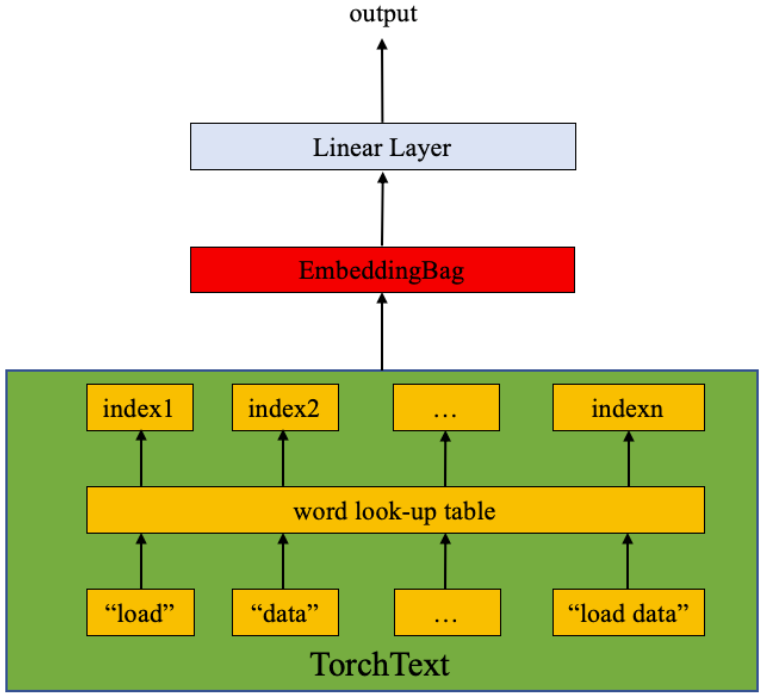
</div>

In [45]:
from torch import nn

class TextClassificationModel(nn.Module):
    
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()
    
    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()
        
    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        out = self.fc(embedded)
        return out

## 5.Initiate an instance

We build a model with the embedding dimension of 64. The vocab size is equal to the length of the vocabulary instance. The number of classes is equal to the number of labels.

In [47]:
train_iter = AG_NEWS(split='train')
num_class = len(set([label for (label, text) in train_iter]))
vocab_size = len(vocab)
emsize = 64
LR = 5

model = TextClassificationModel(vocab_size, emsize, num_class).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)

In [50]:
import time

def train(dataloader):
    model.train()
    total_acc = 0
    total_count = 0
    log_interval = 500
    start_time = time.time()
    
    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)    
        loss.backward()       
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
   
        if idx % log_interval == 0 and idx > 0:
            print('| epoch: {:3d} | batch: [{:5d}/{:5d}] | accuracy {:8.3f}'.format(epoch, idx, len(dataloader), total_acc/total_count))
            total_acc, total_count = 0, 0
            start_time = time.time()


def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0
    
    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)
            loss = criterion(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0) 
    return total_acc / total_count



## 6. Split the dataset and run the mode

We split the training dataset into train/valid sets with a split ratio of 0.95 (train) and 0.05 (valid). Here we use `torch.utils.data.dataset.random_split` function in PyTorch core library. [link](https://pytorch.org/docs/stable/data.html?highlight=random_split#torch.utils.data.random_split)

CrossEntropyLoss criterion combines `nn.LogSoftmax()` and `nn.NLLLoss()` in a single class. It is useful when training a classification problem with C classes. SGD implements stochastic gradient descent method as the optimizer. The initial learning rate is set to 5.0. StepLR is used here to adjust the learning rate through epochs.

In [51]:
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset

# Hyperparameters
EPOCHS = 10

BATCH_SIZE = 64


scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None
train_iter, test_iter = AG_NEWS()
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

num_train = int(len(train_dataset) * 0.8)
split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])
train_dataloader = DataLoader(split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)

for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_dataloader)
    accu_val = evaluate(valid_dataloader)
    if total_accu is not None and total_accu > accu_val:
        scheduler.step()
    else:
        total_accu = accu_val
        
    print('-' * 65)
    print('| end of epoch: {:3d} | time: {:5.2f} | valid accuracy: {:8.3f} '. format(epoch, time.time()-epoch_start_time, accu_val))
    print('-' * 65)

| epoch:   1 | batch: [  500/ 1500] | accuracy    0.894
| epoch:   1 | batch: [ 1000/ 1500] | accuracy    0.896
-----------------------------------------------------------------
| end of epoch:   1 | time: 12.77 | valid accuracy:    0.902 
-----------------------------------------------------------------
| epoch:   2 | batch: [  500/ 1500] | accuracy    0.911
| epoch:   2 | batch: [ 1000/ 1500] | accuracy    0.911
-----------------------------------------------------------------
| end of epoch:   2 | time: 13.09 | valid accuracy:    0.899 
-----------------------------------------------------------------
| epoch:   3 | batch: [  500/ 1500] | accuracy    0.925
| epoch:   3 | batch: [ 1000/ 1500] | accuracy    0.929
-----------------------------------------------------------------
| end of epoch:   3 | time: 13.17 | valid accuracy:    0.909 
-----------------------------------------------------------------
| epoch:   4 | batch: [  500/ 1500] | accuracy    0.930
| epoch:   4 | batch: [ 10

## 7. Evaluate the mode with test dataset

In [52]:
# check the result of the test dataset

print('Reult of the test dataset:')
accu_test = evaluate(test_dataloader)
print('test accuracy {:8.3f}'.format(accu_test))

Reult of the test dataset:
test accuracy    0.903


In [57]:
ag_news_label = {1: 'World',
                 2: 'Sports',
                 3: 'Business',
                 4: 'Sci/Tec'}

def predict(text, text_pipeline):
    with torch.no_grad():
        text = torch.tensor(text_pipeline(text))
        output = model(text,torch.tensor([0]))
        return output.argmax(1).item() + 1
    
News1_kendallJennear ="Instagram influencer Lauren Perez got married this week and her closest\
friends who, for the most part, happen to be A-list celebrities, were in attendance at the \
nuptials.Among the rich and famous guests were supermodels Kendall Jenner and Bella Hadid, \
plus Hailey Bieber and Jesse Jo Stark.For her union with beau David Waltzer, 29-year-old Perez\
wore a strapless silk taffeta dress with a full skirt. The dress featured a sweetheart bandeau\
neckline and a short train, and she paired it with a half veil with lace edging, a simple chain\
necklace and pearl drop earrings."

News2_SGCovidcase = "There are 169 inmates who are currently COVID-19 positive across all of \
Singapore's prison facilities as of Wednesday (10 November). The Singapore Prison Service (SPS)\
said in a media release on Thursday that another 54 supervisees - who are inmates placed on\
community-based programmes - and nine of its staff are also COVID positive."

News3_XaviCoach = "Barcelona has announced the appointment of club legend Xavi Hernández as the\
club's new coach on a deal that includes the remainder of the current season plus two additional\
seasons.He replaces Ronald Koeman, who was sacked last month following a dismal start to the season.\
The club says the 41-year-old Xavi is expected to travel to Barcelona over the weekend ahead of a\
formal presentation as the new head coach at the Camp Nou on Monday. Xavi made a record 767\
appearances for Barcelona, winning eight La Liga titles and four Champions Leagues during his time\
at the Catalan club."

News4_ElonMusk = "Tesla Chief Executive Officer Elon Musk disclosed an additional share sale worth\
about $687 million in the electric-car maker, regulatory filings showed on Friday, after offloading\
about $5 billion in stock earlier in the week.Musk sold 587,638 and 52,099 shares held by his trust\
on Nov. 11 in multiple transactions, according to two separate filings.Tesla shares were up 0.5% at\
$1,069 in premarket trading."

model = model.to("cpu")

print("The first news is about Kendall Jennear")
print("This is a %s news" %ag_news_label[predict(News1_kendallJennear, text_pipeline)])
print()
print("The second news is about Singapore covid cases")
print("This is a %s news" %ag_news_label[predict(News2_SGCovidcase, text_pipeline)])
print()
print("The second news is about Xavi, new coach of Barcelona")
print("This is a %s news" %ag_news_label[predict(News3_XaviCoach, text_pipeline)])
print()
print("The second news is about Elon Musk sell 10% of his share")
print("This is a %s news" %ag_news_label[predict(News4_ElonMusk, text_pipeline)])

The first news is about Kendall Jennear
This is a World news

The second news is about Singapore covid cases
This is a World news

The second news is about Xavi, new coach of Barcelona
This is a Sports news

The second news is about Elon Musk sell 10% of his share
This is a Business news


From the results, the news which are in the same category as the train data did quite well. For news that are not the the category for example style or fashion, the prediction is not good.

### Thanks for reading!